In [ ]:
import numpy as np
from scipy.interpolate import PPoly
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root
from scipy.interpolate import PchipInterpolator
from time import time

!pip install joblib

from joblib import Parallel, delayed

import multiprocessing

import cProfile
import pstats
from pstats import SortKey

PARAMETERS

In [ ]:
# PARAMETERS

Years = 3
deltaT = 0.1
#deltaT = 0.2
# Number of time steps
T = int(Years / deltaT + 1)

# Parameters

alpha = 2 * 2.7947
beta = 0.0035

initialDividend = 2.6968
muD = 0.0139
sigmaD = 0.097

initialZ = 1
muZ = 0
sigmaZ = 1

eps = 0.0096
a = 0.4308

# Share of initial wealth allocated to investor 1

#shareInitialWealth1 = 0.7

# Preferences of representative investor in the complete market

alphaBar = alpha / 2
betaBar = beta

##########
##########
# VALUES FOR THE COMPLETE CASE, EPS = 0
# interest rate
r0 = betaBar + alphaBar * muD - (alphaBar * sigmaD) ** 2 / 2
# stock at time zero
initialStock = initialDividend / r0 + (muD - alphaBar * sigmaD ** 2) / r0 ** 2
# agent 1's wealth at time zero
# initialWealth1 = shareInitialWealth1 * initialStock
# agent 1's initial consumption rate
#initialCons_complete =  alphaBar / alpha * initialDividend + (betaBar - beta) / alpha * (- 1 / r0) + r0 * (initialWealth1 - alphaBar / alpha * initialStock)
# print(f"The initial consumption share in the complete model is {initialCons_complete / initialDividend}")

# Check on parameters
# Negative interest rate
if r0 < 0:
    print("Interest rate is negative!")
# Negative dividend
downD = muD * deltaT - sigmaD * np.sqrt(deltaT)
lowDividend = initialDividend + (T-1) * downD
if lowDividend < 0:
    print("Dividend can be negative!")





# Proportion process parameters
kappa = 0.5       # Speed of mean reversion
xi = 0.6          # Long-term mean of S_t (60% of dividends to stock 1)
sigmaS = 0.2      # Volatility of S_t
initialS = 0.6    # Initial value of S_t, consistent with xi

# Initial dividends for stocks
initialDividend1 = initialDividend * initialS    # D_0^(1)
initialDividend2 = initialDividend * (1 - initialS)  # D_0^(2)

In [ ]:
pm1 = - sigmaZ / r0 / (a + r0) * ( initialDividend * alphaBar + (a + 2 * r0) * alphaBar * (muD - alphaBar * sigmaD **2) / r0 / (a+r0) - 1 )

# Interest rate

print(f"The asymptotic approximation for the interest rate at order 0 is {r0}")
r1 = r0 + eps * alphaBar * sigmaZ * initialZ
print(f"The asymptotic approximation for the interest rate at order 1 is {r1}")

# Bonds

C0 = 1 / r0
C1 = C0 - eps * alphaBar * sigmaZ * initialZ / r0 / (a + r0)
L0 = 1 / r0 / r0
L1 = L0 - eps * (1 / r0 + 1 / (r0 + a) ) * alphaBar * sigmaZ * initialZ / r0 / (a + r0)

def Cf1(initialZ):
  return C0 - eps * alphaBar * sigmaZ * initialZ / r0 / (a + r0)

def Lf1(initialZ):
  return L0 - eps * (1 / r0 + 1 / (r0 + a) ) * alphaBar * sigmaZ * initialZ / r0 / (a + r0)

# Stock

initialStock = initialDividend / r0 + (muD - alphaBar * sigmaD ** 2) / r0 ** 2
P1 = initialDividend * C1 + (muD - alphaBar * sigmaD ** 2) * L1 + eps * sigmaZ * initialZ / r0 / (a + r0)

def Pf1(initialZ, initialDividend):
  return initialDividend * Cf1(initialZ) + (muD - alphaBar * sigmaD ** 2) * Lf1(initialZ) + eps * sigmaZ * initialZ / r0 / (a + r0)

print(f"The asymptotic approximation for the stock price at order 1 is {P1}")

# Second-order

def r2(shareInitialWealth1):
    m1 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * P1 * ( shareInitialWealth1 - alphaBar / alpha) * r0
    m2 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * P1 * ( (1 - shareInitialWealth1 ) - alphaBar / alpha) * r0
    return  r1 - ( eps ** 2 / 4 ) * (m1 ** 2 + m2 ** 2)
print(f"The asymptotic approximation for the interest rate at order 2 is {r2}")

# Third-order

def r3(shareInitialWealth1):
    return  r2(shareInitialWealth1) - (eps * alphaBar * sigmaZ / (a + r0)) ** 3 * r0 ** 2 * ( (2 * a) / (2 * a + r0) * initialZ) * alpha *  P1 * (( shareInitialWealth1 - alphaBar / alpha) ** 2 + ((1 - shareInitialWealth1 ) - alphaBar / alpha) ** 2 )
print(f"The asymptotic approximation for the interest rate at order 2 is {r2}")

# probabilities0 = 0.25 + 0.25 * (np.array([1, 1, -1, -1]) * eps * sigmaZ / sigmaD - np.array([a, -a, a, -a])) * initialZ * np.sqrt(deltaT)
# print(f"The transition probabilities are {probabilities0}")


def theta(shareInitialWealth1):
    m1 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * P1 * ( shareInitialWealth1 - alphaBar / alpha) * r0
    return 0.5 + ( eps * r0 / sigmaD ) ** 2 * pm1 * m1 / alpha / r0


# probabilities0 = 0.25 + 0.25 * (np.array([1, 1, -1, -1]) * eps * sigmaZ / sigmaD - np.array([a, -a, a, -a])) * initialZ * np.sqrt(deltaT)
# print(f"The transition probabilities are {probabilities0}")







# Stock prices for the two assets
initialStock1 = initialDividend * initialS / r0 + (muD * initialS - alphaBar * sigmaD ** 2 * initialS ** 2) / r0 ** 2
initialStock2 = initialDividend * (1 - initialS) / r0 + (muD * (1 - initialS) - alphaBar * sigmaD ** 2 * (1 - initialS) ** 2) / r0 ** 2

print(f"The initial stock price for stock 1 is {initialStock1}")
print(f"The initial stock price for stock 2 is {initialStock2}")

# Stock prices at order 1
P1_1 = initialDividend * initialS * C1 + (muD * initialS - alphaBar * sigmaD ** 2 * initialS ** 2) * L1 + eps * sigmaZ * initialZ / r0 / (a + r0)
P1_2 = initialDividend * (1 - initialS) * C1 + (muD * (1 - initialS) - alphaBar * sigmaD ** 2 * (1 - initialS) ** 2) * L1 + eps * sigmaZ * initialZ / r0 / (a + r0)

print(f"The asymptotic approximation for stock 1 price at order 1 is {P1_1}")
print(f"The asymptotic approximation for stock 2 price at order 1 is {P1_2}")

def Pf1_stock1(initialZ, initialDividend, S):
    return initialDividend * S * Cf1(initialZ) + (muD * S - alphaBar * sigmaD ** 2 * S ** 2) * Lf1(initialZ) + eps * sigmaZ * initialZ / r0 / (a + r0)

def Pf1_stock2(initialZ, initialDividend, S):
    return initialDividend * (1 - S) * Cf1(initialZ) + (muD * (1 - S) - alphaBar * sigmaD ** 2 * (1 - S) ** 2) * Lf1(initialZ) + eps * sigmaZ * initialZ / r0 / (a + r0)


def r2(shareInitialWealth1, S):
    m1 = - (alpha * alphaBar * sigmaZ / (a + r0)) * P1_1 * (shareInitialWealth1 - alphaBar / alpha) * r0 * S
    m2 = - (alpha * alphaBar * sigmaZ / (a + r0)) * P1_2 * ((1 - shareInitialWealth1) - alphaBar / alpha) * r0 * (1 - S)
    return r1 - (eps ** 2 / 4) * (m1 ** 2 + m2 ** 2)

def r3(shareInitialWealth1, S):
    return r2(shareInitialWealth1, S) - (eps * alphaBar * sigmaZ / (a + r0)) ** 3 * r0 ** 2 * ((2 * a) / (2 * a + r0) * initialZ) * alpha * (P1_1 * S + P1_2 * (1 - S)) * ((shareInitialWealth1 - alphaBar / alpha) ** 2 + ((1 - shareInitialWealth1) - alphaBar / alpha) ** 2)


The asymptotic approximation for the interest rate at order 0 is 0.005602547410594988
The asymptotic approximation for the interest rate at order 1 is 0.032431667410594986
The asymptotic approximation for the stock price at order 1 is 85.37569274080595
The asymptotic approximation for the interest rate at order 2 is <function r2 at 0x7e5cdc624790>
The asymptotic approximation for the interest rate at order 2 is <function r2 at 0x7e5cdc624790>
The initial stock price for stock 1 is 252.9283273927505
The initial stock price for stock 2 is 235.63782726713595
The asymptotic approximation for stock 1 price at order 1 is 241.33357642664197
The asymptotic approximation for stock 2 price at order 1 is 225.04372488446074


In [ ]:

# Data to plot for asymptotic expression of interest rate
x_data_asymptotic = np.linspace(0, 1, 100)
y_data_asymptotic = r2(x_data_asymptotic)

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(x_data_asymptotic, y_data_asymptotic, label='Asymptotic Interest Rate', color='red')

# Set the labels for the axes
plt.xlabel('Initial wealth share')
plt.ylabel('Interest rate')

TypeError: r2() missing 1 required positional argument: 'S'

In [ ]:
S_range.shape

In [ ]:
len(r2_values)

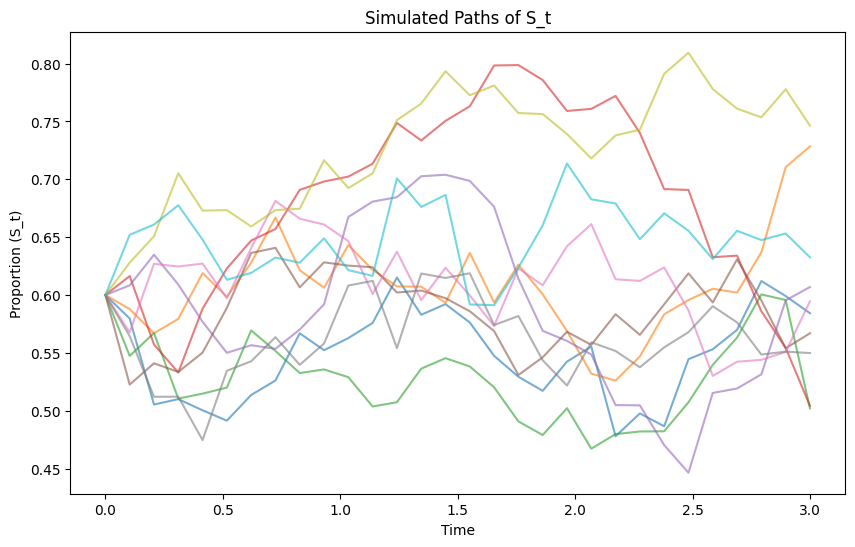

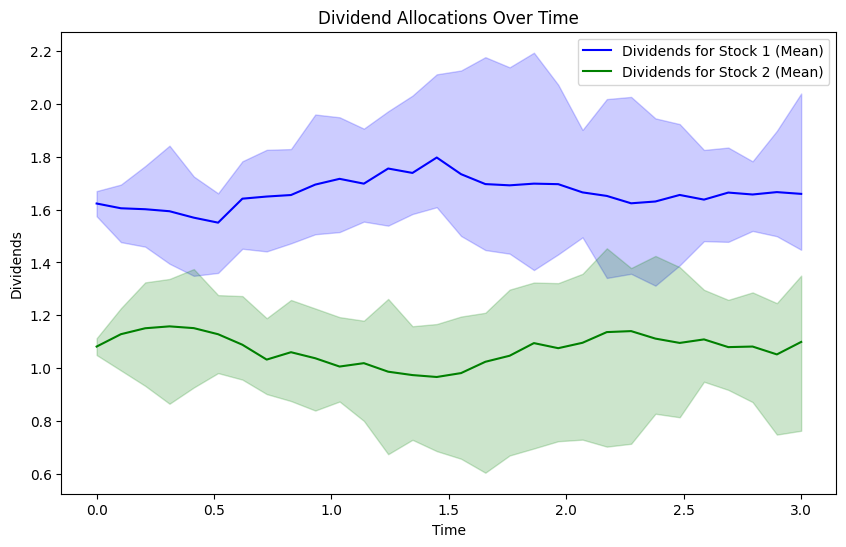

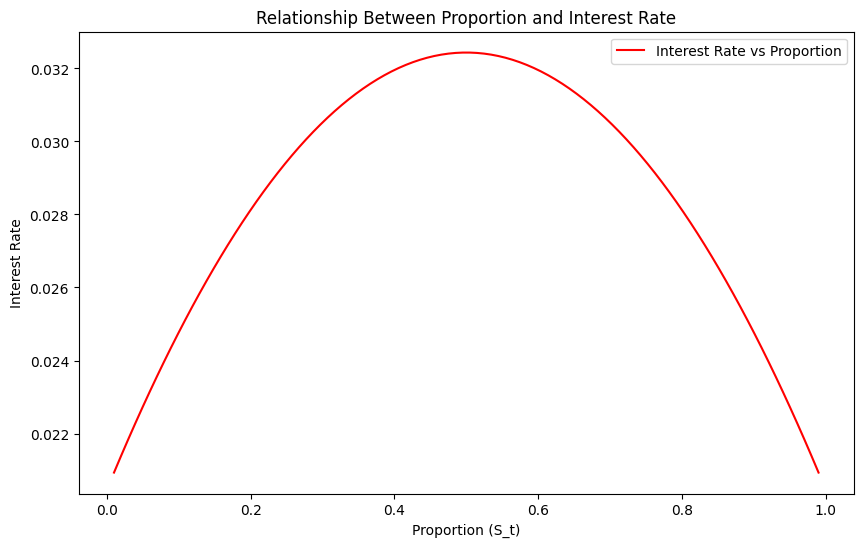

In [ ]:
# Simulate paths for S_t
num_paths = 10
time_steps = int(Years / deltaT)
time_grid = np.linspace(0, Years, time_steps)
S_paths = np.zeros((num_paths, time_steps))
S_paths[:, 0] = initialS

for i in range(1, time_steps):
    dt = deltaT
    dW = np.random.normal(0, np.sqrt(dt), size=num_paths)
    S_paths[:, i] = S_paths[:, i - 1] + kappa * (xi - S_paths[:, i - 1]) * dt + sigmaS * np.sqrt(S_paths[:, i - 1] * (1 - S_paths[:, i - 1])) * dW

# Plot S_t dynamics
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(time_grid, S_paths[i], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Proportion (S_t)')
plt.title('Simulated Paths of S_t')
plt.show()


# Simulate paths for D_t and calculate stock prices
D_paths = initialDividend * np.exp((muD - 0.5 * sigmaD**2) * time_grid + sigmaD * np.random.normal(0, np.sqrt(deltaT), size=(num_paths, time_steps)))





# Plot dividend allocations over time
D1_paths = D_paths * S_paths
D2_paths = D_paths * (1 - S_paths)

plt.figure(figsize=(10, 6))
plt.plot(time_grid, np.mean(D1_paths, axis=0), label="Dividends for Stock 1 (Mean)", color='blue')
plt.plot(time_grid, np.mean(D2_paths, axis=0), label="Dividends for Stock 2 (Mean)", color='green')
plt.fill_between(time_grid, np.percentile(D1_paths, 10, axis=0), np.percentile(D1_paths, 90, axis=0), color='blue', alpha=0.2)
plt.fill_between(time_grid, np.percentile(D2_paths, 10, axis=0), np.percentile(D2_paths, 90, axis=0), color='green', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Dividends')
plt.title('Dividend Allocations Over Time')
plt.legend()
plt.show()




# Interest rate as a function of S_t
S_range = np.linspace(0.01, 0.99, 100)
r2_values = [r2(share, S) for share in x_data_asymptotic for S in S_range]

plt.figure(figsize=(10, 6))
plt.plot(S_range, r2_values[::100], label="Interest Rate vs Proportion", color='red')
plt.xlabel('Proportion (S_t)')
plt.ylabel('Interest Rate')
plt.title('Relationship Between Proportion and Interest Rate')
plt.legend()
plt.show()



FUNCTIONS

In [ ]:
sigma = 1

In [ ]:
def multi_bin_tree(noTimePeriods, muD, sigmaD, deltaT, initialD, initialZ):
    """
    Generates a two-dimensional recombining binomial tree
    that corresponds to the values of [Dt,zt].
    Jump probabilities need to be chosen separately so that the binomial tree
    converges weakly to the corresponding diffusions.
    """
    # Initialization
    binTree = np.full((noTimePeriods, noTimePeriods, noTimePeriods, 2), np.nan)

    # Construction
    # Compute 'up' and 'down' factors
    uD = muD * deltaT + sigmaD * np.sqrt(deltaT)
    dD = muD * deltaT - sigmaD * np.sqrt(deltaT)
    uD = (muD - sigmaD**2/2) * deltaT + sigmaD * np.sqrt(deltaT) ### mon process Y_t = ln(D_t)
    dD = (muD - sigmaD**2/2) * deltaT - sigmaD * np.sqrt(deltaT)



    uz = np.sqrt(deltaT)
    dz = -np.sqrt(deltaT)
    uz = muZ * deltaT + sigma * np.sqrt(deltaT)
    dz = muZ * deltaT - sigma * np.sqrt(deltaT)

    # start from root and create the tree forwards in time
    for t in range(noTimePeriods):
        if t == 0:
            # Set initial value
            binTree[0, 0, 0, 0] = initialD
            binTree[0, 0, 0, 1] = initialZ



            binTree[0, 0, 0, 0] = np.log(initialD)  # Initial Y_t (log of dividend)
            binTree[0, 0, 0, 1] = np.arcsin(2 * initialS - 1)  # Initial Z_t (transformed proportion)

        else:
            for sD in range(t+1):
                for sz in range(t+1):
                    if sD == 0 and sz == 0:
                        # First node in tree is always up movement from first node on last time period
                        binTree[t, sD, sz, 0] = binTree[t-1, sD, sz, 0] + uD
                        binTree[t, sD, sz, 1] = binTree[t-1, sD, sz, 1] + uz
                    elif sD == 0 and sz > 0:
                        binTree[t, sD, sz, 0] = binTree[t-1, sD, sz-1, 0] + uD
                        binTree[t, sD, sz, 1] = binTree[t-1, sD, sz-1, 1] + dz
                    elif sD > 0 and sz == 0:
                        binTree[t, sD, sz, 0] = binTree[t-1, sD-1, sz, 0] + dD
                        binTree[t, sD, sz, 1] = binTree[t-1, sD-1, sz, 1] + uz
                    else:
                        # All other nodes are down-movements from node up in time period before
                        binTree[t, sD, sz, 0] = binTree[t-1, sD-1, sz-1, 0] + dD
                        binTree[t, sD, sz, 1] = binTree[t-1, sD-1, sz-1, 1] + dz

    return binTree

def node_equations_reduced(consAgent1, stateVars, currsplineWealth, currsplineStock):
    """
    States the equations that need to be solved at each node of the binomial tree
    Reduced to 4 equations and 4 unknowns. Two budget equations are linear in agent 1's positions in the risky and
    risk-free assets, and are solved manually.
    decisionVars are agent 1 consumption at the next time step for 4 states of the world (up-up, up-down, down-up, down-down).
    stateVars are the 11 known variables: dividend and z values at the next time step,
    current dividend and z, agent 1's current share of consumption.
    currsplineWealth, currsplineStock are cubic splines for agent 1's wealth and the stock
    at the next time step (for the 4 states of the world)
    """

    # Unpack state variables
    dividends = stateVars[:4]  # Dividends for up-up, up-down, down-up, down-down
    z_values = stateVars[4:8]  # Z values for up-up, up-down, down-up, down-down
    currentDividend = stateVars[8]
    currentZ = stateVars[9]
    agent1Share = stateVars[10]



    # Calculate S_t for each state
    shares = 0.5 * (1 + np.sin(z_values))  # S_t = 0.5 * (1 + sin(Z_t))

    # Calculate split dividends
    dividends_1 = dividends * shares
    dividends_2 = dividends * (1 - shares)

    # Get current proportion of dividends
    currentProportion = 0.5 * (1 + np.sin(currentZ))



    # From Consumption-clearing conditions
    consAgent2 = dividends - consAgent1

    # Unpack parameters
    alpha, beta, sigmaZ, eps, a, deltaT = parameters

    # Calculate agent 1's consumption shares for each next time step state
    agent1ShareNext = consAgent1 / dividends

    # Evaluate stock and wealth at agent 1's consumption shares at next time step
    stockPrices = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    stockPrices_1 = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    stockPrices_2 = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    wealths = np.array([
        currsplineWealth['upup'](agent1ShareNext[0]),
        currsplineWealth['updown'](agent1ShareNext[1]),
        currsplineWealth['downup'](agent1ShareNext[2]),
        currsplineWealth['downdown'](agent1ShareNext[3])
    ])

    # compute agent 1 position in assets by solving manually 2 budget equations
    stockAgent1 = ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT))
    safeAgent1 = consAgent1[0] * deltaT + wealths[0] - stockAgent1 * (stockPrices[0] + dividends[0] * deltaT)

    stockAgent1_1 = ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) / ((stockPrices_1[0] + dividends_1[0] * deltaT) - (stockPrices_1[3] + dividends_1[3] * deltaT))
    stockAgent1_2 = ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) / ((stockPrices_2[0] + dividends_2[0] * deltaT) - (stockPrices_2[3] + dividends_2[3] * deltaT))

    safeAgent1 = consAgent1[0] * deltaT + wealths[0] - stockAgent1_1 * (stockPrices_1[0] + dividends_1[0] * deltaT) - stockAgent1_2 * (stockPrices_2[0] + dividends_2[0] * deltaT)

    stockAgent2_1 = ((consAgent2[0] * deltaT + wealths[0]) - (consAgent2[3] * deltaT + wealths[3])) / ((stockPrices_1[0] + dividends_1[0] * deltaT) - (stockPrices_1[3] + dividends_1[3] * deltaT))
    safeAgent2 = consAgent2[0] * deltaT + wealths[0] - stockAgent2_1 * (stockPrices_1[0] + dividends_1[0] * deltaT)



    # Calculate probabilities for each state transition
    probabilities = 0.25 + 0.25 * (np.array([1, 1, -1, -1]) * eps * sigmaZ / sigmaD - np.array([a, -a, a, -a])) * currentZ * np.sqrt(deltaT)

    # Calculate stochastic discount factors
    SDF1 = np.exp(-beta * deltaT - alpha * (consAgent1 - agent1Share * currentDividend))
    SDF2 = np.exp(-beta * deltaT - alpha * (consAgent2 - (1 - agent1Share) * currentDividend))
    #logSDF1 = -beta * deltaT - alpha * (consAgent1 - agent1Share * currentDividend)
    #logSDF2 = -beta * deltaT - alpha * (consAgent2 - (1 - agent1Share) * currentDividend)



    # List of 4 equations that need to be satisfied
    fvals = np.zeros(4)
    # Two remaining budget conditions
    fvals[0] = consAgent1[1] * deltaT + wealths[1] - (safeAgent1 + stockAgent1 * (stockPrices[1] + dividends[1] * deltaT))
    fvals[1] = consAgent1[2] * deltaT + wealths[2] - (safeAgent1 + stockAgent1 * (stockPrices[2] + dividends[2] * deltaT))
    # Kernel conditions: agents agree on stock price and interest rate
    #fvals[2] = np.sum(probabilities * SDF1 * (stockPrices + dividends * deltaT)) - np.sum(probabilities * SDF2 * (stockPrices + dividends * deltaT))
    fvals[2] = np.sum(probabilities * (SDF1 - SDF2) * (stockPrices + dividends * deltaT))
    fvals[2] = np.sum(probabilities * (SDF1 - SDF2) * (stockPrices_1 + dividends_1 * deltaT))

    fvals[3] = np.sum(probabilities * (SDF1 - SDF2))

    # CHANGING fvals[3]
    #mean1, variance1 = mean_variance(logSDF1, probabilities)
    #mean2, variance2 = mean_variance(logSDF2, probabilities)
    #fvals[3] = (variance1 / 2 + mean1 ) - (variance2 / 2 + mean2 )
    return fvals

def gradient_equations(decisionVars, stateVars, currsplineWealth, currsplineStock, derCurrWealth, derCurrStock):
    """
    Compute the gradient of the 4 equations defined in the function node_equations_reduced
    The gradient is passed to the equation solver to speed up computations
    """

    # Unpack decision variables
    consAgent1 = decisionVars[:4]

    # Unpack state variables
    dividends = stateVars[:4]  # Dividends for up-up, up-down, down-up, down-down
    z_values = stateVars[4:8]  # Z values for up-up, up-down, down-up, down-down
    currentDividend = stateVars[8]
    currentZ = stateVars[9]
    agent1Share = stateVars[10]

    # From Consumption-clearing conditions
    consAgent2 = dividends - consAgent1

    # Unpack parameters
    alpha, beta, sigmaZ, eps, a, deltaT = parameters

    # Calculate agent shares for each state
    agent1ShareNext = consAgent1 / dividends

    # Evaluate stock, wealth, derivative of stock and derivative of wealth at agent 1's consumption shares at next time step
    stockPrices = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    stockPrices_1 = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    stockPrices_2 = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    wealths = np.array([
        currsplineWealth['upup'](agent1ShareNext[0]),
        currsplineWealth['updown'](agent1ShareNext[1]),
        currsplineWealth['downup'](agent1ShareNext[2]),
        currsplineWealth['downdown'](agent1ShareNext[3])
    ])
    derStockPrices = np.array([
        derCurrStock['upup'](agent1ShareNext[0]),
        derCurrStock['updown'](agent1ShareNext[1]),
        derCurrStock['downup'](agent1ShareNext[2]),
        derCurrStock['downdown'](agent1ShareNext[3])
    ])
    derWealths = np.array([
        derCurrWealth['upup'](agent1ShareNext[0]),
        derCurrWealth['updown'](agent1ShareNext[1]),
        derCurrWealth['downup'](agent1ShareNext[2]),
        derCurrWealth['downdown'](agent1ShareNext[3])
    ])

    # Calculate probabilities for each state transition
    probabilities = 0.25 + 0.25 * ( np.array([1, 1, -1, -1]) * eps * sigmaZ /sigmaD - np.array([a, -a, a, -a])) * currentZ * np.sqrt(deltaT)

    # Calculate stochastic discount factors
    SDF1 = np.exp(-beta * deltaT - alpha * (consAgent1 - agent1Share * currentDividend))
    SDF2 = np.exp(-beta * deltaT - alpha * (consAgent2 - (1 - agent1Share) * currentDividend))
    #logSDF1 = -beta * deltaT - alpha * (consAgent1 - agent1Share * currentDividend)
    #logSDF2 = -beta * deltaT - alpha * (consAgent2 - (1 - agent1Share) * currentDividend)

    # agent 1 position in assets
    stockAgent1 = ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT))
    safeAgent1 = consAgent1[0] * deltaT + wealths[0] - stockAgent1 * (stockPrices[0] + dividends[0] * deltaT)

    # derivatives of agent 1 position in assets with respect to consAgent1[0], consAgent1[3]
    der0StockAgent1 =  ( deltaT + derWealths[0] / dividends[0] ) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT)) - \
     ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) * ( derStockPrices[0] / dividends[0] ) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT))**2
    der3StockAgent1 =  - ( deltaT + derWealths[3] / dividends[3] ) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT)) - \
     ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) * ( - derStockPrices[3] / dividends[3] ) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT))**2
    der0SafeAgent1 =  deltaT + derWealths[0] / dividends[0] - der0StockAgent1 * (stockPrices[0] + dividends[0] * deltaT) - stockAgent1 * derStockPrices[0] / dividends[0]
    der3SafeAgent1 = - der3StockAgent1 * (stockPrices[0] + dividends[0] * deltaT)

    # calculate gradient (rows equations, columns variables)
    gradient = np.zeros((4, 4))

    # Derivatives of budget equations with respect to consumption

    gradient[0,0] = - (der0SafeAgent1 + der0StockAgent1 * (stockPrices[1] + dividends[1] * deltaT))
    gradient[0,1] = deltaT + derWealths[1] / dividends[1] - stockAgent1 * derStockPrices[1] / dividends[1]
    gradient[0,3] = - (der3SafeAgent1 + der3StockAgent1 * (stockPrices[1] + dividends[1] * deltaT))

    gradient[1,0] = - (der0SafeAgent1 + der0StockAgent1 * (stockPrices[2] + dividends[2] * deltaT))
    gradient[1,2] = deltaT + derWealths[2] / dividends[2] - stockAgent1 * derStockPrices[2] / dividends[2]
    gradient[1,3] = - (der3SafeAgent1 + der3StockAgent1 * (stockPrices[2] + dividends[2] * deltaT))

    #mean1, variance1 = mean_variance(logSDF1, probabilities)
    #mean2, variance2 = mean_variance(logSDF2, probabilities)

    # Derivatives of kernel equations with respect to consumption
    for i in range(4):
        gradient[2,i] = probabilities[i] * ( SDF1[i] * ( - alpha * (stockPrices[i] + dividends[i] * deltaT) + derStockPrices[i] / dividends[i] ) + \
                                            SDF2[i] * (- alpha * (stockPrices[i] + dividends[i] * deltaT) - derStockPrices[i] / dividends[i] ) )
        gradient[2,i] = probabilities[i] * ( - alpha) * ( SDF1[i] + SDF2[i] ) * (stockPrices[i] + dividends[i] * deltaT) + probabilities[i] * (SDF1[i] - SDF2[i]) * derStockPrices[i] / dividends[i]
        gradient[3,i] = probabilities[i] * ( - alpha ) * ( SDF1[i]  + SDF2[i] )
        # CHANGING gradient[3,i]
        #dermean1 = - alpha * probabilities[i]
        #dermean2 = alpha * probabilities[i]
        #dervar1 = -2 * dermean1 * np.sum((logSDF1 - mean1) * probabilities) + 2 * (logSDF1[i] - mean1) * ( - alpha) * probabilities[i]
        #dervar2 = -2 * dermean2 * np.sum((logSDF2 - mean2) * probabilities) + 2 * (logSDF2[i] - mean2) * ( alpha) * probabilities[i]
        #gradient[3,i] = (dervar1 / 2 + dermean1 ) - (dervar2 / 2 + dermean2 )

    return gradient

def exit_values_reduced(consAgent1, stateVars, currsplineWealth, currsplineStock):
    """
    Given agent 1 consumption at the next time step for 4 states of the world, returns
    agent 2 consumption, agent 1 position in the two assets, agent 1 wealth and stock price
    """

    # Unpack state variables
    dividends = stateVars[:4]  # Dividends for up-up, up-down, down-up, down-down
    z_values = stateVars[4:8]  # Z values for up-up, up-down, down-up, down-down
    currentDividend = stateVars[8]
    currentZ = stateVars[9]
    agent1Share = stateVars[10]

    # From Consumption-clearing conditions
    consAgent2 = dividends - consAgent1

    # Unpack parameters
    alpha, beta, sigmaZ, eps, a, deltaT = parameters

    # Calculate agent shares for each state
    agent1ShareNext = consAgent1 / dividends

    # Evaluate stock and wealth at agent 1's consumption shares at next time step
    stockPrices = np.array([
        currsplineStock['upup'](agent1ShareNext[0]),
        currsplineStock['updown'](agent1ShareNext[1]),
        currsplineStock['downup'](agent1ShareNext[2]),
        currsplineStock['downdown'](agent1ShareNext[3])
    ])
    wealths = np.array([
        currsplineWealth['upup'](agent1ShareNext[0]),
        currsplineWealth['updown'](agent1ShareNext[1]),
        currsplineWealth['downup'](agent1ShareNext[2]),
        currsplineWealth['downdown'](agent1ShareNext[3])
    ])

    # compute agent 1 position in assets by solving 2 budget equations
    stockAgent1 = ((consAgent1[0] * deltaT + wealths[0]) - (consAgent1[3] * deltaT + wealths[3])) / ((stockPrices[0] + dividends[0] * deltaT) - (stockPrices[3] + dividends[3] * deltaT))
    safeAgent1 = consAgent1[0] * deltaT + wealths[0] - stockAgent1 * (stockPrices[0] + dividends[0] * deltaT)

    # Calculate probabilities for each state transition
    probabilities = 0.25 + 0.25 * (np.array([1, 1, -1, -1]) * eps * sigmaZ / sigmaD - np.array([a, -a, a, -a])) * currentZ * np.sqrt(deltaT)

    # Calculate stochastic discount factors
    SDF1 = np.exp(-beta * deltaT - alpha * (consAgent1 - agent1Share * currentDividend))
    SDF2 = np.exp(-beta * deltaT - alpha * (consAgent2 - (1 - agent1Share) * currentDividend))

    # Compute exiting wealth and stock prices
    exitWealth = np.sum(probabilities * SDF1 * (wealths + consAgent1 * deltaT))
    exitStock = np.sum(probabilities * SDF1 * (stockPrices + dividends * deltaT))

    return consAgent2, stockAgent1, safeAgent1, exitWealth, exitStock

def first_node(decisionVars, currentDividend, currentZ, parameters, shareInitWealthAgent1, currsplineWealth, currsplineStock):
    """
    States the equations that need to be solved at the root of the binomial tree
    to identify initial consumption share of each agent
    """

    # Extract consumption values for agent 1 and agent 2
    consAgent1, consAgent2 = decisionVars[0], decisionVars[1]

    # Compute consumption share of agent 1
    agent1Share = consAgent1 / currentDividend

    # Evaluate optimal wealth and stock at the consumption share
    optWealth = currsplineWealth(agent1Share)
    optStock = currsplineStock(agent1Share)

    # Compute equations to be satisfied at node zero
    fvals = np.zeros(2)
    # Agent 1's initial wealth share matches the exogenous value
    fvals[0] = optWealth / optStock - shareInitWealthAgent1
    # Market clearing for consumption
    fvals[1] = consAgent1 + consAgent2 - currentDividend

    return fvals

def mean_variance(X, P):
    assert len(X) == len(P), "Arrays X and P must have the same length"

    # Calculate mean E[X]
    mean = sum(x * p for x, p in zip(X, P))

    # Calculate variance Var(X)
    variance = sum((x - mean) ** 2 * p for x, p in zip(X, P))

    return mean, variance

FUNCTIONS FOR PARALLEL COMPUTING

In [ ]:
def equations_node_parallel( sD, sz):
    """
    grid contains all possible values for agent 1's current share of consumption.
    Given a node (sD, sz) of the two-dimensional binomial tree, we solve len(grid) systems of equation,
    each system was set up in the function node_equations_reduced
    """

    # State variables: dividend and z on next time step, current dividend, current z
    stateVars_pre = np.array([
      binTree[t+1, sD, sz, 0],
      binTree[t+1, sD, sz+1, 0],
      binTree[t+1, sD+1, sz, 0],
      binTree[t+1, sD+1, sz+1, 0],
      binTree[t+1, sD, sz, 1],
      binTree[t+1, sD, sz+1, 1],
      binTree[t+1, sD+1, sz, 1],
      binTree[t+1, sD+1, sz+1, 1],
      binTree[t, sD, sz, 0],
      binTree[t, sD, sz, 1]])

    optimalValues = [None] * len(grid)
    exitWealth = [None] * len(grid)
    stockPrice = [None] * len(grid)
    exitflag_list = [None] * len(grid)
    msg_list = [None] * len(grid)

    # Keys for 4 states in next time step
    keys = ['upup', 'updown', 'downup', 'downdown']
    offsets = [(0, 0), (0, 1), (1, 0), (1, 1)]

    # wealth and stock price as a function of agent 1's current consumption share, and their derivatives
    # for each of the next 4 states
    # currsplineWealth_L, currsplineStock_L, derCurrWealth_L, derCurrStock_L have been defined in the main code
    currsplineWealth = {}
    currsplineStock = {}
    derCurrWealth = {}
    derCurrStock = {}

    for key, offset in zip(keys, offsets):
        i, j = offset
        currsplineWealth[key] = currsplineWealth_L[sD+i, sz+j]
        currsplineStock[key] = currsplineStock_L[sD+i, sz+j]
        derCurrWealth[key] = derCurrWealth_L[sD+i, sz+j]
        derCurrStock[key] = derCurrStock_L[sD+i, sz+j]

    # For each value of the grid, solve the system of equations
    for w in range(len(grid)):

        # Current value for consumption share
        omega = grid[w]

        # State variables
        stateVars = np.append(stateVars_pre, omega)

        # initial guess for decision variables
        if w == 0:
            # If we are at the first grid value,
            # take a random guess (e.g., consumptions and positions are identical for the two agents)
            x0 = np.array([0.5 * stateVars[0], 0.5 * stateVars[1], 0.5 * stateVars[2], 0.5 * stateVars[3]])
        else:
            # If we are at later points of grid,
            # use optimal values from the grid point before
            x0 = x

        # Equations to solve
        # Wrapper turns it into a function that takes decisionVars (the unknowns to find)
        # and outputs the equations to solve
        def equation_wrapper(decisionVars):
            return node_equations_reduced(decisionVars, stateVars, currsplineWealth, currsplineStock)

        # Gradient of the equations
        # Wrapper turns it into a function that takes decisionVars (the unkowns to find)
        # and outputs the gradient
        def gradient_wrapper(decisionVars):
            return gradient_equations(decisionVars, stateVars, currsplineWealth, currsplineStock, derCurrWealth, derCurrStock)

        # Solve the equations at the current node for a given level of consumption share
        # x contains the array decisionVars that solves the equations
        x, infodict, exitflag, msg = fsolve(equation_wrapper, x0, fprime=gradient_wrapper, full_output=True, **options)

        # output agent 2's consumption rate, agent 1's asset holdings, agent 1's wealth and stock price for the optimal decisionVars x
        consAgent2, stockAgent1, safeAgent1, exitWealthValue, exitStockValue = exit_values_reduced(x, stateVars,
                                                  currsplineWealth, currsplineStock)

        # Store optimal values
        optimalValues[w] = [omega] + x.tolist() + consAgent2.tolist() + [stockAgent1] + [safeAgent1]

        # Store stock price and wealth
        exitWealth[w] = [omega] + [exitWealthValue]
        stockPrice[w] = [omega] + [exitStockValue]
        exitflag_list[w] = [omega] + [exitflag]
        msg_list[w] = [omega] + [msg]

    return (sD, sz, [optimalValues, exitWealth, stockPrice, exitflag_list, msg_list])

def create_chunks(t, chunk_size):
    """
    takes the set of nodes of the binomial tree at time t and splits them into chunks of size chunk_size
    """
    # nodes at time t
    tasks = [(sD, sz) for sD in range(t+1) for sz in range(t+1)]
    # chunks of nodes
    chunks = [tasks[i:i + chunk_size] for i in range(0, len(tasks), chunk_size)]
    return chunks

def process_chunk(chunk):
    """
    takes a chunk of nodes and solves the systems of equations for each node in the chunk (and each value of the grid)
    """
    results = []
    for sD, sz in chunk:
        result = equations_node_parallel(sD, sz)
        results.append(result)
    return results



MAIN CODE

In [ ]:
sigma = 1

In [ ]:
# Setting up possible values of initial wealth

n_nodes = 0
n_nodes_corr = 0

WealthShareValues = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

interestRate_wealth = []
position_wealth = []

# Grid setup
# Grid for consumption share of agent 1
grid = np.array([0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
#start_array = np.array([0.01])
#increment_array = np.arange(0.05, 1.0, 0.05)
#end_array = np.array([0.99])
#grid = np.concatenate((start_array, increment_array, end_array))

# Define optimization options, using 'fsolve' in scipy
options = {'maxfev': 5000, 'xtol': 1e-9}

# Set of parameters
parameters = np.array([alpha, beta, sigmaZ, eps, a, deltaT])

# Number of cores to be used for parallel computing
num_cores = multiprocessing.cpu_count()
print(f'Number of CPU cores available: {num_cores}')

start_time = time()


# Build the tree

binTree = multi_bin_tree(T, muD, sigmaD, deltaT, initialDividend, initialZ)

# Initialize
results = {}
optimalDecisions = {}
iterations = []
iterations_grad = []

# Storing agent 1 wealth and stock price (and derivatives)
# as functions of agent 1 consumption share for each node
currsplineWealth_L = {}
currsplineStock_L = {}
derCurrWealth_L = {}
derCurrStock_L = {}

# START OF BACKWARD RECURSION

# Start the loop from the second to last time step
for t in range(T-2, -1, -1):

    del currsplineWealth_L, currsplineStock_L, derCurrWealth_L, derCurrStock_L
    currsplineWealth_L = {}
    currsplineStock_L = {}
    currsplineWealth_coeff = {}
    currsplineStock_coeff = {}
    derCurrWealth_L = {}
    derCurrStock_L = {}

    # Compute agent 1 wealth and stock functions for all nodes at time t+1
    for sD in range(t+2):
        for sz in range(t+2):

            # Second last time step
            if t == T - 2:
                  # Dividends at final nodes
                  finalDividend = binTree[t+1, sD, sz, 0]
                  # Z at final nodes
                  finalZ = binTree[t+1, sD, sz, 1]

                  # Set some values for final stock price and final agent 1 wealth
                  # We choose to set them equal to the value for eps = 0
                  # at each final node, stock price is a constant function of agent 1 consumption share
                  stock_final = finalDividend / r0 + (muD - alphaBar * sigmaD ** 2) / r0 ** 2
                  stock_final = Pf1(finalZ, finalDividend)
                  # at each final node, wealth is a linear function of agent 1 consumption share
                  wealth_final = grid * finalDividend / r0 + 0.5 * (muD - alphaBar * sigmaD ** 2) / r0 ** 2
                  wealth_final = grid * finalDividend * Cf1(finalZ) + 0.5 * (Pf1(finalZ, finalDividend) - finalDividend * Cf1(finalZ))

                  # Create spline interpolators for wealth and stock given their values on the grid
                  currsplineWealth_L[(sD, sz)] = PchipInterpolator(grid, wealth_final)
                  currsplineStock_L[(sD, sz)] = PchipInterpolator(grid, np.ones_like(grid) * stock_final)
                  derCurrWealth_L[(sD, sz)] = currsplineWealth_L[(sD, sz)].derivative()
                  derCurrStock_L[(sD, sz)] = currsplineStock_L[(sD, sz)].derivative()

                  #degree = 1
                  #currsplineWealth_coeff[(sD, sz)] = np.polyfit(grid, grid * finalDividend * Cf1(finalZ) + 0.5 * (Pf1(finalZ, finalDividend) - finalDividend * Cf1(finalZ)), degree)
                  #currsplineStock_coeff[(sD, sz)] = np.polyfit(grid, np.ones_like(grid) * Pf1(finalZ, finalDividend), degree)
                  #currsplineWealth_L[(sD, sz)] = np.poly1d(currsplineWealth_coeff[(sD, sz)])
                  #currsplineStock_L[(sD, sz)] = np.poly1d(currsplineStock_coeff[(sD, sz)])
                  #derCurrWealth_L[(sD, sz)] = currsplineWealth_L[(sD, sz)].deriv()
                  #derCurrStock_L[(sD, sz)] = currsplineStock_L[(sD, sz)].deriv()

            else:
                  # Take stock/wealth output computed for t+1
                  # Interpolate wealth and stock over grid points
                  currsplineWealth_L[(sD, sz)] = PchipInterpolator(grid, results[t+1, sD, sz]['exitWealth'][:,1])
                  currsplineStock_L[(sD, sz)] = PchipInterpolator(grid, results[t+1, sD, sz]['stockPrice'][:,1])
                  derCurrWealth_L[(sD, sz)] = currsplineWealth_L[(sD, sz)].derivative()
                  derCurrStock_L[(sD, sz)] = currsplineStock_L[(sD, sz)].derivative()

                  #degree = 1
                  #currsplineWealth_coeff[(sD, sz)] = np.polyfit(grid, results[t+1, sD, sz]['exitWealth'][:,1], degree)
                  #currsplineStock_coeff[(sD, sz)] = np.polyfit(grid, results[t+1, sD, sz]['stockPrice'][:,1], degree)
                  #currsplineWealth_L[(sD, sz)] = np.poly1d(currsplineWealth_coeff[(sD, sz)])
                  #currsplineStock_L[(sD, sz)] = np.poly1d(currsplineStock_coeff[(sD, sz)])
                  #derCurrWealth_L[(sD, sz)] = currsplineWealth_L[(sD, sz)].deriv()
                  #derCurrStock_L[(sD, sz)] = currsplineStock_L[(sD, sz)].deriv()


    # PARALLEL COMPUTING
    # Split nodes at time t into num_cores chunks
    # Each core will then process one chunk

    chunk_size = int((t+1)**2 / num_cores) + 1
    chunks = create_chunks(t, chunk_size)

    # Parallel processing using joblib
    results_parallel_pre = Parallel(n_jobs=num_cores)(delayed(process_chunk)(chunk) for chunk in chunks)

    # Store results
    results_parallel = [item for sublist in results_parallel_pre for item in sublist]

    for sD in range(t+1):
        for sz in range(t+1):

            if (t, sD, sz) not in results:
                results[(t, sD, sz)] = {'optimalValues': [], 'exitWealth': [], 'stockPrice': [], 'exitflag':[], 'msg':[]}
                results[(t, sD, sz)]['optimalValues'] = np.zeros((len(grid), 11))
                results[(t, sD, sz)]['exitWealth'] = np.zeros((len(grid), 2))
                results[(t, sD, sz)]['stockPrice'] = np.zeros((len(grid), 2))
                results[(t, sD, sz)]['exitflag'] = np.zeros((len(grid), 2))
                results[(t, sD, sz)]['msg'] = {}

                specific_result = next((result for i, j, result in results_parallel if i == sD and j == sz), None)

                for w in range(len(grid)):
                    results[(t, sD, sz)]['optimalValues'][w] = specific_result[0][w]
                    results[(t, sD, sz)]['exitWealth'][w] = specific_result[1][w]
                    results[(t, sD, sz)]['stockPrice'][w] = specific_result[2][w]
                    results[(t, sD, sz)]['exitflag'][w] = specific_result[3][w]
                    results[(t, sD, sz)]['msg'][w] = specific_result[4][w]

                    n_nodes += 1

                    if results[(t, sD, sz)]['exitflag'][w][1] != 1:
                        print(results[(t, sD, sz)]['msg'][w])
                        print(results[(t, sD, sz)]['exitWealth'][w])
                        currentDividend = binTree[t, sD, sz, 0]
                        currentZ = binTree[t, sD, sz, 1]
                        results[(t, sD, sz)]['stockPrice'][w] = [grid[w], Pf1(currentZ, currentDividend) ]
                        results[(t, sD, sz)]['exitWealth'][w] = [grid[w] , grid[w] * currentDividend * Cf1(currentZ) + 0.5 * (Pf1(currentZ, currentDividend) - currentDividend * Cf1(currentZ)) ]
                        print(results[(t, sD, sz)]['exitWealth'][w])
                        n_nodes_corr += 1


print(n_nodes_corr/n_nodes)

# FORWARD STEP AT ROOT NODE

for shareInitialWealth1 in WealthShareValues:

      # Initial guess for optimal consumption rate of agents 1 and 2
      x0 = np.array([0.5 * initialDividend, 0.5 * initialDividend])

      # Interpolate agent 1 wealth/stock price over grid values at root node
      currsplineWealth = PchipInterpolator(grid, results[0, 0, 0]['exitWealth'][:, 1])
      currsplineStock = PchipInterpolator(grid, results[0, 0, 0]['stockPrice'][:, 1])

      # Equations to solve at root node
      # Wrapper turns it into a function that takes decisionVars
      # and outputs the equations to solve
      def rootNode_equation_wrapper(decisionVars):
          return first_node(decisionVars, binTree[0, 0, 0, 0], binTree[0, 0, 0, 1],
                                      [alpha, beta, sigmaZ, eps, a, deltaT], shareInitialWealth1,
                                      currsplineWealth, currsplineStock)

      # Solves the root node equations
      x, info, ier, msg = fsolve(rootNode_equation_wrapper, x0, full_output=True, **options)

      if ier != 1:
          print('Optimization did not converge:', msg)

      print(f"The equilibrium consumption share of agent 1 is {x[0]/initialDividend}")
      print(f"The equilibrium stock price is {currsplineStock(x[0]/initialDividend)}")

      # Clear not needed variables
      del x0, info, ier, msg, currsplineWealth, currsplineStock

      # Optimal consumption at initial node
      optimalDecisions = {}
      optimalDecisions[(0, 0, 0)] = {
          'consAgent1': x[0],
          'consAgent2': x[1]
      }

      # Note: Optimal consumption at future times does not depend only on the node on the tree,
      # but also on the path to get to that node
      # To compute the equilibrium interest rate, we compute the optimal consumption rates at time t=1

      # Agent 1 optimal consumption share
      optConsumptionShare = optimalDecisions[(0, 0, 0)]['consAgent1'] / binTree[t, sD, sz, 0]
      # Retrieve the optimal decisions found in the backward iteration part, and interpolate over the grid
      currsplineOptValues = PchipInterpolator(grid, results[(t, sD, sz)]['optimalValues'][:, 1:11])
      # Evaluate these functions at the optimal consumption share value, found in the forward step
      intValues = currsplineOptValues(optConsumptionShare)

      # Store the values for optimal consumption at time t = 1 and optimal investment at time t = 0
      root_holdings = {'stockAgent1': intValues[8],'safeAgent1': intValues[9]}
      optimalDecisions[(0, 0, 0)].update(root_holdings)
      optimalDecisions[(1, 0, 0)] = {'consAgent1': intValues[0],'consAgent2': intValues[4]}
      optimalDecisions[(1, 0, 1)] = {'consAgent1': intValues[1], 'consAgent2': intValues[5]}
      optimalDecisions[(1, 1, 0)] = {'consAgent1': intValues[2], 'consAgent2': intValues[6]}
      optimalDecisions[(1, 1, 1)] = {'consAgent1': intValues[3], 'consAgent2': intValues[7]}

      # Transition probabilities at root node
      probabilities_root = 0.25 + 0.25 * (np.array([1, 1, -1, -1]) * eps * sigmaZ / sigmaD - np.array([a, -a, a, -a])) * initialZ * np.sqrt(deltaT)
      # Compute stochastic discount factors
      consAgent1 = np.array([
              optimalDecisions[(1, 0, 0)]['consAgent1'],
              optimalDecisions[(1, 0, 1)]['consAgent1'],
              optimalDecisions[(1, 1, 0)]['consAgent1'],
              optimalDecisions[(1, 1, 1)]['consAgent1']
          ])
      consAgent2 = np.array([
              optimalDecisions[(1, 0, 0)]['consAgent2'],
              optimalDecisions[(1, 0, 1)]['consAgent2'],
              optimalDecisions[(1, 1, 0)]['consAgent2'],
              optimalDecisions[(1, 1, 1)]['consAgent2']
          ])
      SDF1_root = np.exp(-beta * deltaT - alpha * (consAgent1 - optimalDecisions[(0, 0, 0)]['consAgent1']))
      SDF2_root = np.exp(-beta * deltaT - alpha * (consAgent2 - optimalDecisions[(0, 0, 0)]['consAgent2']))
      logSDF1 = -beta * deltaT - alpha * (consAgent1 - optimalDecisions[(0, 0, 0)]['consAgent1'])
      logSDF2 = -beta * deltaT - alpha * (consAgent2 - optimalDecisions[(0, 0, 0)]['consAgent2'])
      mean, variance = mean_variance(logSDF1, probabilities_root)
      # Compute the equilibrium interest rate from the SDFs
      interestRate = - ( np.sum(probabilities_root * SDF1_root) - 1 ) / deltaT
      print(f"The equilibrium interest rate is {interestRate}")
      interestRate = - (variance / 2 + mean ) / deltaT
      print(f"The equilibrium interest rate is {interestRate}")

      # Add interest rate to the list
      interestRate_wealth.append(interestRate)
      position_wealth.append(intValues[8])

# Clean up
del t, sD, sz, optConsumptionShare, currsplineOptValues, intValues

# Print time elapsed
print(f'Time elapsed: {time() - start_time:.2f} seconds')

# Extract data for plotting
# x: initialZ
x_data = WealthShareValues
# y: interest rate
y_data = interestRate_wealth

# Data to plot for asymptotic expression of interest rate
x_data_asymptotic = np.linspace(0.1, 0.9, 20)
y_data_asymptotic = r2(x_data_asymptotic)

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(x_data, y_data, label='Numeric Interest Rate',marker='o', color='blue')
plt.plot(x_data_asymptotic, y_data_asymptotic, label='Asymptotic Interest Rate', color='red')

# Set the labels for the axes
plt.xlabel('Initial wealth share of agent 1')
plt.ylabel('Interest rate')

# Show the plot
plt.legend()
plt.show()

Streaming output truncated to the last 5000 lines.
[   0.3       -136.7958494]
[0.4, 'The iteration is not making good progress, as measured by the \n  improvement from the last five Jacobian evaluations.']
[   0.4        -340.70279819]
[   0.4        -123.54642936]
[0.5, 'The iteration is not making good progress, as measured by the \n  improvement from the last five Jacobian evaluations.']
[ 5.00000000e-01 -6.08521756e+02]
[   0.5        -110.29700933]
[0.7, 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.']
[  0.7        -78.76083925]
[  0.7        -83.79816926]
[0.8, 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.']
[  0.8        -30.86314883]
[  0.8        -70.54874923]
[0.9, 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.']
[  0.9        195.86770288]
[  0.9       -57.2993292]
[0.99, 'The iteration is

TypeError: r2() missing 1 required positional argument: 'S'

In [ ]:
print(f'Time elapsed: {time() - start_time:.2f} seconds')

# Extract data for plotting
# x: initialZ
x_data = WealthShareValues
# y: interest rate
y_data = position_wealth

# Data to plot for asymptotic expression of interest rate
x_data_asymptotic = np.linspace(0.1, 0.9, 9)
y_data_asymptotic = 0.5 + (theta(x_data_asymptotic) - 0.5) /2
y_data_asymptotic_2 = theta(x_data_asymptotic)

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(x_data, y_data, label='Numeric Stock Position',marker='o', color='blue')
# plt.plot(x_data_asymptotic, y_data_asymptotic, label='Wrong Asymptotic Stock Position', color='green')
plt.plot(x_data_asymptotic, y_data_asymptotic_2, label='Asymptotic Stock Position', color='red')

# Set the labels for the axes
plt.xlabel('Initial wealth share of agent 1')
plt.ylabel('Stock Position')

# Show the plot
plt.legend()
plt.show()

In [ ]:
print(type(interestRate))

In [ ]:
print(f'Time elapsed: {time() - start_time:.2f} seconds')

# Extract data for plotting
# x: initialZ
x_data = WealthShareValues
# y: interest rate
y_data = position_wealth

# Data to plot for asymptotic expression of interest rate
x_data_asymptotic = np.linspace(0.1, 0.9, 9)
y_data_asymptotic = 0.5 + (theta(x_data_asymptotic) - 0.5) /2
y_data_asymptotic_2 = theta(x_data_asymptotic)

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(x_data, y_data, label='Numeric Stock Position',marker='o', color='blue')
plt.plot(x_data_asymptotic, y_data_asymptotic, label='Wrong Asymptotic Stock Position', color='red')
plt.plot(x_data_asymptotic, y_data_asymptotic_2, label='Real Asymptotic Stock Position', color='green')

# Set the labels for the axes
plt.xlabel('Initial wealth')
plt.ylabel('Stock Position')

# Show the plot
plt.legend()
plt.show()

In [ ]:
print(y_data)
print(y_data_asymptotic)

In [ ]:
def rr2(shareInitialWealth1):
    m1 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * initialStock * ( shareInitialWealth1 - alphaBar / alpha) * r0
    m2 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * initialStock * ( (1 - shareInitialWealth1 ) - alphaBar / alpha) * r0
    return  r1 - ( eps ** 2 / 8 ) * (m1 ** 2 + m2 ** 2)

x_data = WealthShareValues
# y: interest rate
y_data = interestRate_wealth

# Data to plot for asymptotic expression of interest rate
x_data_asymptotic = np.linspace(0.1, 0.9, 20)
y_data_asymptotic = r2(x_data_asymptotic)

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(x_data, y_data, label='Numeric Interest Rate',marker='o', color='blue')
plt.plot(x_data_asymptotic, y_data_asymptotic, label='Asymptotic Interest Rate', color='red')

# Set the labels for the axes
plt.xlabel('Initial z')
plt.ylabel('Interest rate')

# Show the plot
plt.legend()
plt.show()

In [ ]:
def r2(shareInitialWealth1):
    m1 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * initialStock * ( shareInitialWealth1 - alphaBar / alpha) * r0
    m2 = - ( alpha * alphaBar * sigmaZ / (a + r0) ) * initialStock * ( (1 - shareInitialWealth1 ) - alphaBar / alpha) * r0
    return  r1 - ( eps ** 2 / 8 ) * (m1 ** 2 + m2 ** 2)

x_data = WealthShareValues
# y: interest rate
y_data = interestRate_wealth

# Data to plot for asymptotic expression of interest rate
x_data_asymptotic = np.linspace(0.1, 0.9, 20)
y_data_asymptotic = r2(x_data_asymptotic)

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(x_data, y_data, label='Numeric Interest Rate',marker='o', color='blue')
plt.plot(x_data_asymptotic, y_data_asymptotic, label='Asymptotic Interest Rate', color='red')

# Set the labels for the axes
plt.xlabel('Initial z')
plt.ylabel('Interest rate')

# Show the plot
plt.legend()
plt.show()

In [ ]:
x_data = WealthShareValues
# y: interest rate
y_data = interestRate_wealth

# Data to plot for asymptotic expression of interest rate
y_data_asymptotic = r2(x_data)

In [ ]:
y_data
y_data_asymptotic = []
for x in x_data:
  y_data_asymptotic.append(r2(x))

[100*(a - b)/a for a, b in zip(y_data,y_data_asymptotic)]

In [ ]:
y_data
y_data_asymptotic = []
for x in x_data:
  y_data_asymptotic.append(r2(x))

[100*(a - b)/a for a, b in zip(y_data,y_data_asymptotic)]

In [ ]:
aa = [2,3,4,5,6]
bb = [5,2.7,2,1.6,1.4]
bb2 = [1/5,1/2.7,1/2,1/1.6,1/1.4]

# Create a new figure
plt.figure(1)

# Plot the data
plt.plot(aa,bb2)

# Show the plot
plt.show()